### Notebook to prepare the full dataset used for training of different models, combining different code throughout this repo


In [52]:
# Importing Libraries

import pandas as pd
import healpy as hp
import numpy as np
import pickle

In [26]:
# Defining important metrics and functions

# Setting NSIDE values
NSIDE = 256
NPIX = hp.nside2npix(NSIDE)
print(
    "Approximate resolution at NSIDE {} is {:.2} deg".format(
        NSIDE, hp.nside2resol(NSIDE, arcmin=True) / 60
    )
)
print(
    "Approximate resolution at NSIDE {} is {:.2} deg".format(
        NSIDE, hp.nside2pixarea(NSIDE, degrees=True)))

def raDec2thetaPhi(ra, dec):
    return (0.5 * np.pi - np.deg2rad(dec)), (np.deg2rad(ra))


Approximate resolution at NSIDE 256 is 0.23 deg
Approximate resolution at NSIDE 256 is 0.052 deg


### 1. Get a catalogue of all objects in the Galaxy Survey



In [6]:
df_north = pd.read_csv('../../bricks_data/galaxy_catalogue_north.csv', dtype={'BrickID': 'int32', 'LRG': 'int8', 'ELG': 'int8', 'QSO': 'int8'})

df_north.head()


,BrickID,RA,DEC,LRG,ELG,QSO
0,541202,140.895285,39.405974,0,0,1
1,541202,140.895584,39.576038,0,0,1
2,541202,140.895693,39.403449,0,0,1
3,541202,140.896081,39.479529,0,0,1
4,541202,140.896304,39.621573,0,1,0


In [7]:
df_south = pd.read_csv('../../bricks_data/galaxy_catalogue_south.csv', dtype={'BrickID': 'int32', 'LRG': 'int8', 'ELG': 'int8', 'QSO': 'int8'})

df_south.head()


,BrickID,RA,DEC,LRG,ELG,QSO
0,387694,350.870568,9.868695,1,0,0
1,387694,350.871680,9.637755,0,1,0
2,387694,350.872142,9.694869,0,0,1
3,387694,350.872631,9.724626,0,0,1
4,387694,350.873243,9.683394,0,1,0


In [9]:
print(len(df_north.BrickID.unique()))
print(len(df_south.BrickID.unique()))
print(len(df_north.BrickID.unique()) + len(df_south.BrickID.unique()))

89085
229267
318352


In [13]:
df = pd.concat((df_south,df_north), axis=0)

In [15]:
print(len(df))

307973


In [16]:
print(df.shape)
duplicates_removed = df.drop_duplicates()

print(duplicates_removed.shape)

(112179772, 6)
(112145572, 6)


In [22]:
df = duplicates_removed

print(len(df.BrickID.unique()))

307973


In [20]:
print(df.isna().sum())

BrickID         0
RA         132602
DEC        132602
LRG             0
ELG             0
QSO             0
dtype: int64


In [24]:
# Removing all Lines with Nan that were added to ensure that all bricks are stored
df_objects = df.dropna(axis=0, inplace=False, how='any')

print(len(df_objects.BrickID.unique()))
print(len(df_objects))

302013
112012970


### 2. Get Galaxy Count per Healpy Pixel


In [27]:
# LRG

df_LRG = df_objects[df_objects["LRG"] == 1]
ra_LRG = df_LRG["RA"].to_numpy(copy=True)
dec_LRG = df_LRG["DEC"].to_numpy(copy=True)
theta, phi = raDec2thetaPhi(ra_LRG, dec_LRG)

print("Number of LRGs in Sample:", len(ra_LRG))

LRG_pixel_indices = hp.ang2pix(NSIDE, theta,phi)


# Finding out unique indices and how often they appear --> shows the density of LRGs in this pixel
(unique, counts) = np.unique(LRG_pixel_indices, return_counts=True)

print(unique)

mean_LRG = counts.mean()
print("Mean LRGs per Pixel:", mean_LRG)
# Calculating Densities for every block

#density_LRG = (counts / mean_LRG) - 1
id_density = np.stack((unique, counts), axis=1)
#print(id_density)
df_lrg = pd.DataFrame(id_density, columns=['pixel_id', 'lrg'])
df_lrg.pixel_id = df_lrg.pixel_id.astype(int)
df_lrg.head()

Number of LRGs in Sample: 12471061
[  1558   1560   1561 ... 757955 758427 758428]
Mean LRGs per Pixel: 33.2510198422644


,pixel_id,lrg
0,1558,2
1,1560,1
2,1561,3
3,1562,1
4,1564,2


In [28]:
# elg

df_ELG = df_objects[df_objects["ELG"] == 1]
ra_ELG = df_ELG["RA"].to_numpy(copy=True)
dec_ELG = df_ELG["DEC"].to_numpy(copy=True)
theta, phi = raDec2thetaPhi(ra_ELG, dec_ELG)

print("Number of ELGs in Sample:", len(ra_ELG))

ELG_pixel_indices = hp.ang2pix(NSIDE, theta,phi)


# Finding out unique indices and how often they appear --> shows the density of LRGs in this pixel
(unique, counts) = np.unique(ELG_pixel_indices, return_counts=True)

print(unique)

mean_ELG = counts.mean()
print("Mean ELGs per Pixel:", mean_ELG)
# Calculating Densities for every block
#density_ELG = (counts / mean_ELG) - 1
id_density = np.stack((unique, counts), axis=1)
print(id_density)
df_elg = pd.DataFrame(id_density, columns=['pixel_id', 'elg'])
df_elg.pixel_id = df_elg.pixel_id.astype(int)

print(df_elg.head())

Number of ELGs in Sample: 46596018
[  1558   1559   1560 ... 758428 758429 758430]
Mean ELGs per Pixel: 123.5948976939359
[[  1558      6]
 [  1559      3]
 [  1560      7]
 ...
 [758428     12]
 [758429      4]
 [758430      6]]
   pixel_id  elg
0      1558    6
1      1559    3
2      1560    7
3      1561    4
4      1562    5


In [29]:
df_QSO = df_objects[df_objects["QSO"] == 1]
ra_QSO = df_QSO["RA"].to_numpy(copy=True)
dec_QSO = df_QSO["DEC"].to_numpy(copy=True)
theta, phi = raDec2thetaPhi(ra_QSO, dec_QSO)

print("Number of QSOs in Sample:", len(ra_QSO))

QSO_pixel_indices = hp.ang2pix(NSIDE, theta,phi)


# Finding out unique indices and how often they appear --> shows the density of LRGs in this pixel
(unique, counts) = np.unique(QSO_pixel_indices, return_counts=True)

print(unique)

mean_QSO = counts.mean()
print("Mean QSOs per Pixel:", mean_QSO)
# Calculating Densities for every block
#density_QSO = (counts / mean_QSO) - 1
id_density = np.stack((unique, counts), axis=1)
print(id_density)
df_qso = pd.DataFrame(id_density, columns=['pixel_id', 'qso'])
df_qso.pixel_id = df_qso.pixel_id.astype(int)

print(df_qso.head())

Number of QSOs in Sample: 58293615
[  1558   1559   1560 ... 758428 758429 758430]
Mean QSOs per Pixel: 154.52905888652666
[[  1558      9]
 [  1559      5]
 [  1560      8]
 ...
 [758428      6]
 [758429      6]
 [758430      4]]
   pixel_id  qso
0      1558    9
1      1559    5
2      1560    8
3      1561    6
4      1562    6


In [30]:
df = pd.merge(df_lrg, df_elg, how='outer', on='pixel_id')
df = pd.merge(df, df_qso, how='outer', on='pixel_id')
print(df.isna().sum())
print(df_lrg.shape, df_elg.shape, df_qso.shape, df.shape)

pixel_id       0
lrg         2546
elg          598
qso          370
dtype: int64
(375058, 2) (377006, 2) (377234, 2) (377604, 4)


In [31]:
# Dropping all pixels where I do not have counts for all 3 types of galaxies
df.dropna(axis=0, inplace=True)
print(df.isna().sum())
print( df.shape)

pixel_id    0
lrg         0
elg         0
qso         0
dtype: int64
(374783, 4)


### 3. Plotting Galaxy Densities

0.0 180.0 -180.0 180.0


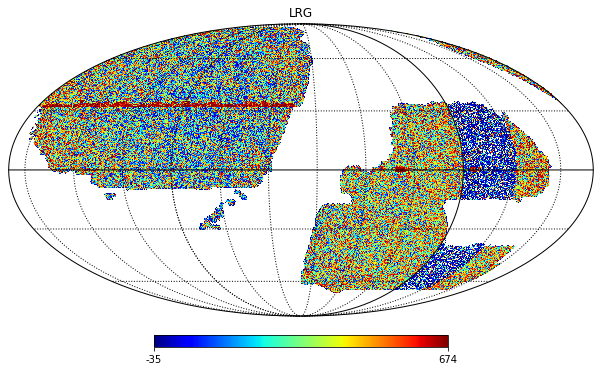

In [49]:
m_LRG = np.zeros(NPIX)

m_LRG[df.pixel_id.to_numpy()] = df.lrg.to_numpy()
mask = (m_LRG == 0)
m_LRG[mask] = np.nan
hp.mollview(m_LRG, title="LRG", format='%i' ,norm='hist', cmap="jet", notext=False, rot=(100,0,0), badcolor='white', remove_dip=True, remove_mono=True)
hp.graticule()

0.0 180.0 -180.0 180.0


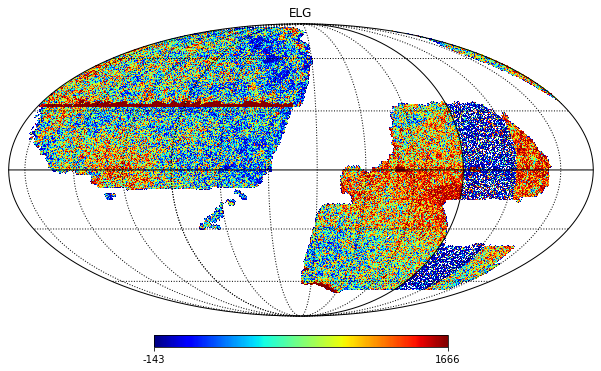

In [50]:
m_ELG = np.zeros(NPIX)

m_ELG[df.pixel_id.to_numpy()] = df.elg.to_numpy()
mask = (m_ELG == 0)
m_ELG[mask] = np.nan
hp.mollview(m_ELG, title="ELG", format='%i' ,norm='hist', cmap="jet", notext=False, rot=(100,0,0), badcolor='white', remove_dip=True, remove_mono=True)
hp.graticule()

0.0 180.0 -180.0 180.0


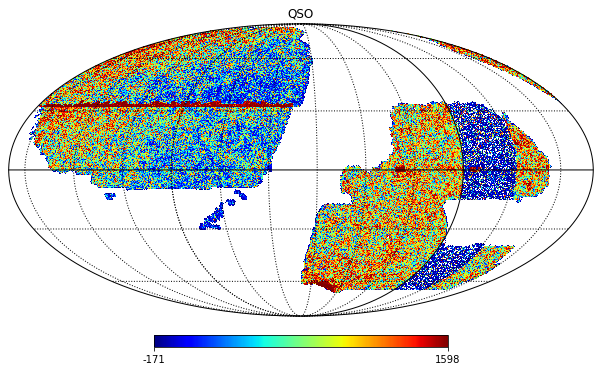

In [51]:
m_QSO = np.zeros(NPIX)

m_QSO[df.pixel_id.to_numpy()] = df.qso.to_numpy()
mask = (m_QSO == 0)
m_QSO[mask] = np.nan
hp.mollview(m_QSO, title="QSO", format='%i' ,norm='hist', cmap="jet", notext=False, rot=(100,0,0), badcolor='white', remove_dip=True, remove_mono=True)
hp.graticule()

In [64]:
# Getting Exposure Densities across pixels

with open('../../bricks_data/pixel2ccd_256.pickle', 'rb') as f:
    pixel2ccd_dict = pickle.load(f)
    f.close()

In [65]:
df = df.astype(int)
df.head()

,pixel_id,lrg,elg,qso,exposures
0,1558,2,6,9,0
1,1560,1,7,8,0
2,1561,3,4,6,0
3,1562,1,5,6,0
4,1564,2,4,10,0


In [66]:
df_exp = df
#df_exp['exposures'] = np.zeros(len(df_exp))
df_exp.head()

,pixel_id,lrg,elg,qso,exposures
0,1558,2,6,9,0
1,1560,1,7,8,0
2,1561,3,4,6,0
3,1562,1,5,6,0
4,1564,2,4,10,0


In [68]:
pix_ids = df_exp.pixel_id.to_numpy()
exp_len = np.zeros(len(pix_ids))
print(pix_ids)
for i, pix in enumerate(pix_ids):
    exp_len[i] = len(pixel2ccd_dict[pix])

print(exp_len)

df_exp['exposures'] = exp_len

df_exp.head()

[  1558   1560   1561 ... 757955 758427 758428]
[10. 11. 10. ...  8.  6.  9.]


,pixel_id,lrg,elg,qso,exposures
0,1558,2,6,9,10.0
1,1560,1,7,8,11.0
2,1561,3,4,6,10.0
3,1562,1,5,6,10.0
4,1564,2,4,10,10.0


0.0 180.0 -180.0 180.0


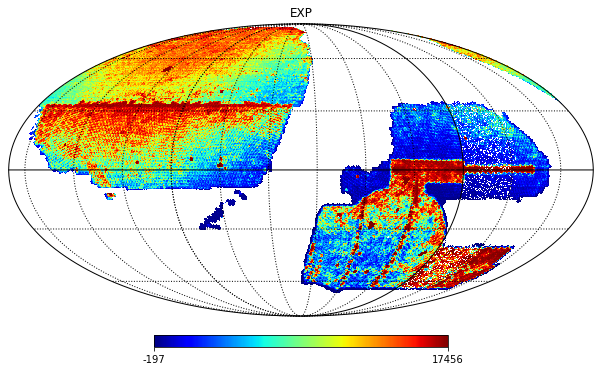

In [69]:
m_EXP = np.zeros(NPIX)

m_EXP[df.pixel_id.to_numpy()] = df.exposures.to_numpy()
mask = (m_EXP == 0)
m_EXP[mask] = np.nan
hp.mollview(m_EXP, title="EXP", format='%i' ,norm='hist', cmap="jet", notext=False, rot=(100,0,0), badcolor='white', remove_dip=True, remove_mono=True)
hp.graticule()